# Human Activity Recognition using Hidden Markov Models

## Imports

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from scipy.fft import fft, fftfreq
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

print(" All packages imported successfully!")

 All packages imported successfully!


## Data Loading

In [152]:
class UniversalDataLoader:
    def __init__(self):
        self.activities = ['standing', 'walking', 'jumping', 'still']
        self.users = ['excel', 'lesly']
    
    def find_data_files(self):
        """Find all data files regardless of directory structure"""
        all_files = []
        
        # Method 1: Search recursively for CSV files
        csv_files = glob("**/*.csv", recursive=True)
        
        # Method 2: Try specific known paths
        known_paths = [
            "data/excel/jumping/*.csv",
            "data/excel/standing/*.csv", 
            "data/excel/walking/*.csv",
            "data/excel/still/*.csv",
            "data/lesly/jumping/*.csv",
            "data/lesly/standing/*.csv",
            "data/lesly/walking/*.csv", 
            "data/lesly/still/*.csv",
            "excel/jumping/*.csv",
            "excel/standing/*.csv",
            "excel/walking/*.csv",
            "excel/still/*.csv",
            "lesly/jumping/*.csv",
            "lesly/standing/*.csv",
            "lesly/walking/*.csv",
            "lesly/still/*.csv"
        ]
        
        for path in known_paths:
            files = glob(path)
            if files:
                print(f" Found {len(files)} files at: {path}")
                all_files.extend(files)
        
        # Remove duplicates
        all_files = list(set(all_files))
        return all_files
    
    def extract_info_from_path(self, file_path):
        """Extract user and activity from file path"""
        path_parts = file_path.split('/')
        
        # Try to find user and activity in path
        user = None
        activity = None
        
        for part in path_parts:
            if part in self.users:
                user = part
            if part in self.activities:
                activity = part
        
        return user, activity
    
    def load_all_data(self):
        """Load all data files"""
        all_files = self.find_data_files()
        
        if not all_files:
            print(" No CSV files found! Creating sample data...")
            return self.create_sample_data()
        
        all_data = []
        
        for file_path in all_files:
            try:
                df = pd.read_csv(file_path)
                user, activity = self.extract_info_from_path(file_path)
                
                if user and activity:
                    df['user'] = user
                    df['activity'] = activity
                    df['file_id'] = os.path.basename(file_path)
                    all_data.append(df)
                    print(f" Loaded: {file_path} ({len(df)} rows)")
                else:
                    print(f"  Could not determine user/activity for: {file_path}")
                    
            except Exception as e:
                print(f" Error loading {file_path}: {e}")
        
        if not all_data:
            raise ValueError("No data could be loaded!")
            
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n SUCCESS! Loaded {len(combined_df)} rows from {len(all_data)} files")
        return combined_df
    
    def create_sample_data(self):
        """Create sample data if real data not found"""
        print(" Creating realistic sample data...")
        
        np.random.seed(42)
        sampling_rate = 50
        duration = 10
        samples_per_file = duration * sampling_rate
        
        all_data = []
        
        for user in self.users:
            for activity in self.activities:
                num_files = 6
                
                for file_num in range(1, num_files + 1):
                    time = np.linspace(0, duration, samples_per_file)
                    
                    if activity == 'standing':
                        accel_x = 0.1 * np.random.normal(0, 0.2, samples_per_file)
                        accel_y = 9.8 + 0.1 * np.random.normal(0, 0.2, samples_per_file)
                        accel_z = 0.1 * np.random.normal(0, 0.2, samples_per_file)
                        gyro_x = 0.05 * np.random.normal(0, 0.1, samples_per_file)
                        gyro_y = 0.05 * np.random.normal(0, 0.1, samples_per_file)
                        gyro_z = 0.05 * np.random.normal(0, 0.1, samples_per_file)
                        
                    elif activity == 'walking':
                        freq = 2.0
                        accel_x = 1.5 * np.sin(2 * np.pi * freq * time) + 0.3 * np.random.normal(0, 0.5, samples_per_file)
                        accel_y = 9.8 + 0.8 * np.sin(2 * np.pi * freq * time + np.pi/2) + 0.2 * np.random.normal(0, 0.3, samples_per_file)
                        accel_z = 0.5 * np.sin(2 * np.pi * freq * time + np.pi/4) + 0.2 * np.random.normal(0, 0.3, samples_per_file)
                        gyro_x = 0.8 * np.sin(2 * np.pi * freq * time) + 0.1 * np.random.normal(0, 0.2, samples_per_file)
                        gyro_y = 0.6 * np.sin(2 * np.pi * freq * time + np.pi/3) + 0.1 * np.random.normal(0, 0.2, samples_per_file)
                        gyro_z = 0.4 * np.sin(2 * np.pi * freq * time + np.pi/6) + 0.1 * np.random.normal(0, 0.2, samples_per_file)
                        
                    elif activity == 'jumping':
                        jump_freq = 0.7
                        accel_x = 3.0 * np.sin(2 * np.pi * jump_freq * time) + 1.0 * np.random.normal(0, 1.0, samples_per_file)
                        accel_y = 9.8 + 4.0 * np.sin(2 * np.pi * jump_freq * time + np.pi/2) + 1.0 * np.random.normal(0, 1.0, samples_per_file)
                        accel_z = 2.0 * np.sin(2 * np.pi * jump_freq * time + np.pi/4) + 0.8 * np.random.normal(0, 0.8, samples_per_file)
                        gyro_x = 2.0 * np.sin(2 * np.pi * jump_freq * time) + 0.5 * np.random.normal(0, 0.5, samples_per_file)
                        gyro_y = 1.5 * np.sin(2 * np.pi * jump_freq * time + np.pi/3) + 0.5 * np.random.normal(0, 0.5, samples_per_file)
                        gyro_z = 1.2 * np.sin(2 * np.pi * jump_freq * time + np.pi/6) + 0.5 * np.random.normal(0, 0.5, samples_per_file)
                        
                    elif activity == 'still':
                        accel_x = 0.01 * np.random.normal(0, 0.05, samples_per_file)
                        accel_y = 9.8 + 0.01 * np.random.normal(0, 0.05, samples_per_file)
                        accel_z = 0.01 * np.random.normal(0, 0.05, samples_per_file)
                        gyro_x = 0.01 * np.random.normal(0, 0.02, samples_per_file)
                        gyro_y = 0.01 * np.random.normal(0, 0.02, samples_per_file)
                        gyro_z = 0.01 * np.random.normal(0, 0.02, samples_per_file)
                    
                    file_data = pd.DataFrame({
                        'timestamp': time,
                        'accel_x': accel_x,
                        'accel_y': accel_y,
                        'accel_z': accel_z,
                        'gyro_x': gyro_x,
                        'gyro_y': gyro_y,
                        'gyro_z': gyro_z,
                        'user': user,
                        'activity': activity,
                        'file_id': f'{user}{file_num}_{activity}.csv'
                    })
                    
                    all_data.append(file_data)
        
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f" Created sample data: {len(combined_df)} rows")
        return combined_df

# Load data with universal loader
print("\n Loading data with universal loader...")
data_loader = UniversalDataLoader()
df = data_loader.load_all_data()

# Show what we loaded
print("\n Sample of loaded data:")
print(df.head())
print(f"\n Data shape: {df.shape}")
print(f"Users: {df['user'].unique()}")
print(f"Activities: {df['activity'].unique()}")
print(f"Files: {df['file_id'].nunique()}")


 Loading data with universal loader...
 No CSV files found! Creating sample data...
 Creating realistic sample data...
 Created sample data: 24000 rows

 Sample of loaded data:
   timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z  \
0    0.00000  0.009934  9.818524  0.027987  0.003892 -0.003376  0.002853   
1    0.02004 -0.002765  9.838188  0.018493 -0.002756 -0.000723  0.004841   
2    0.04008  0.012954  9.772029  0.001193 -0.004091 -0.003962 -0.001657   
3    0.06012  0.030461  9.811259 -0.012939 -0.000017 -0.001540 -0.003061   
4    0.08016 -0.004683  9.786987  0.013964 -0.000851 -0.009468 -0.005426   

    user  activity              file_id  
0  excel  standing  excel1_standing.csv  
1  excel  standing  excel1_standing.csv  
2  excel  standing  excel1_standing.csv  
3  excel  standing  excel1_standing.csv  
4  excel  standing  excel1_standing.csv  

 Data shape: (24000, 10)
Users: ['excel' 'lesly']
Activities: ['standing' 'walking' 'jumping' 'still']
Files: 48

## Data Quality Check and Column Mapping

In [ ]:
def analyze_and_clean_data(df):
    """Analyze and clean the loaded data"""
    print("="*60)
    print(" DATA QUALITY ANALYSIS")
    print("="*60)
    
    # Show basic info
    print(f"Total rows: {len(df)}")
    print(f"Total files: {df['file_id'].nunique()}")
    print(f"Users: {df['user'].unique().tolist()}")
    print(f"Activities: {df['activity'].unique().tolist()}")
    
    # Show all columns
    print(f"\nAll columns: {df.columns.tolist()}")
    
    # Map actual column names to standard names
    column_mapping = {}
    for col in df.columns:
        col_lower = col.lower()
        # Map accelerometer columns
        if 'accel' in col_lower or 'ax' == col_lower or 'ay' == col_lower or 'az' == col_lower:
            if 'x' in col_lower or col == 'ax':
                column_mapping[col] = 'accel_x'
            elif 'y' in col_lower or col == 'ay':
                column_mapping[col] = 'accel_y'
            elif 'z' in col_lower or col == 'az':
                column_mapping[col] = 'accel_z'
        # Map gyroscope columns
        elif 'gyro' in col_lower or 'gx' == col_lower or 'gy' == col_lower or 'gz' == col_lower or 'gfx' in col_lower or 'gfy' in col_lower or 'gfz' in col_lower:
            if 'x' in col_lower or col == 'gx' or 'gfx' in col_lower:
                column_mapping[col] = 'gyro_x'
            elif 'y' in col_lower or col == 'gy' or 'gfy' in col_lower:
                column_mapping[col] = 'gyro_y'
            elif 'z' in col_lower or col == 'gz' or 'gfz' in col_lower:
                column_mapping[col] = 'gyro_z'
        # Map timestamp
        elif 'time' in col_lower or 'timestamp' in col_lower:
            column_mapping[col] = 'timestamp'
    
    print(f"\n Column mapping: {column_mapping}")
    
    # Apply mapping
    df = df.rename(columns=column_mapping)
    
    # Check sensors
    sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    available_sensors = [col for col in sensor_cols if col in df.columns]
    print(f" Available sensors after mapping: {available_sensors}")
    
    # Data distribution
    print(f"\n Data distribution:")
    dist_table = df.groupby(['user', 'activity']).agg({
        'file_id': 'nunique',
        'timestamp': 'count'
    }).rename(columns={'file_id': 'num_files', 'timestamp': 'num_samples'})
    print(dist_table)
    
    return df, available_sensors

# Analyze and clean data
df, available_sensors = analyze_and_clean_data(df)


 DATA QUALITY ANALYSIS
Total rows: 24000
Total files: 48
Users: ['excel', 'lesly']
Activities: ['standing', 'walking', 'jumping', 'still']

All columns: ['timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'user', 'activity', 'file_id']

🔧 Column mapping: {'timestamp': 'timestamp', 'accel_x': 'accel_x', 'accel_y': 'accel_y', 'accel_z': 'accel_z', 'gyro_x': 'gyro_x', 'gyro_y': 'gyro_y', 'gyro_z': 'gyro_y'}
 Available sensors after mapping: ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y']

 Data distribution:
                num_files  num_samples
user  activity                        
excel jumping           6         3000
      standing          6         3000
      still             6         3000
      walking           6         3000
lesly jumping           6         3000
      standing          6         3000
      still             6         3000
      walking           6         3000


## Data Visualization

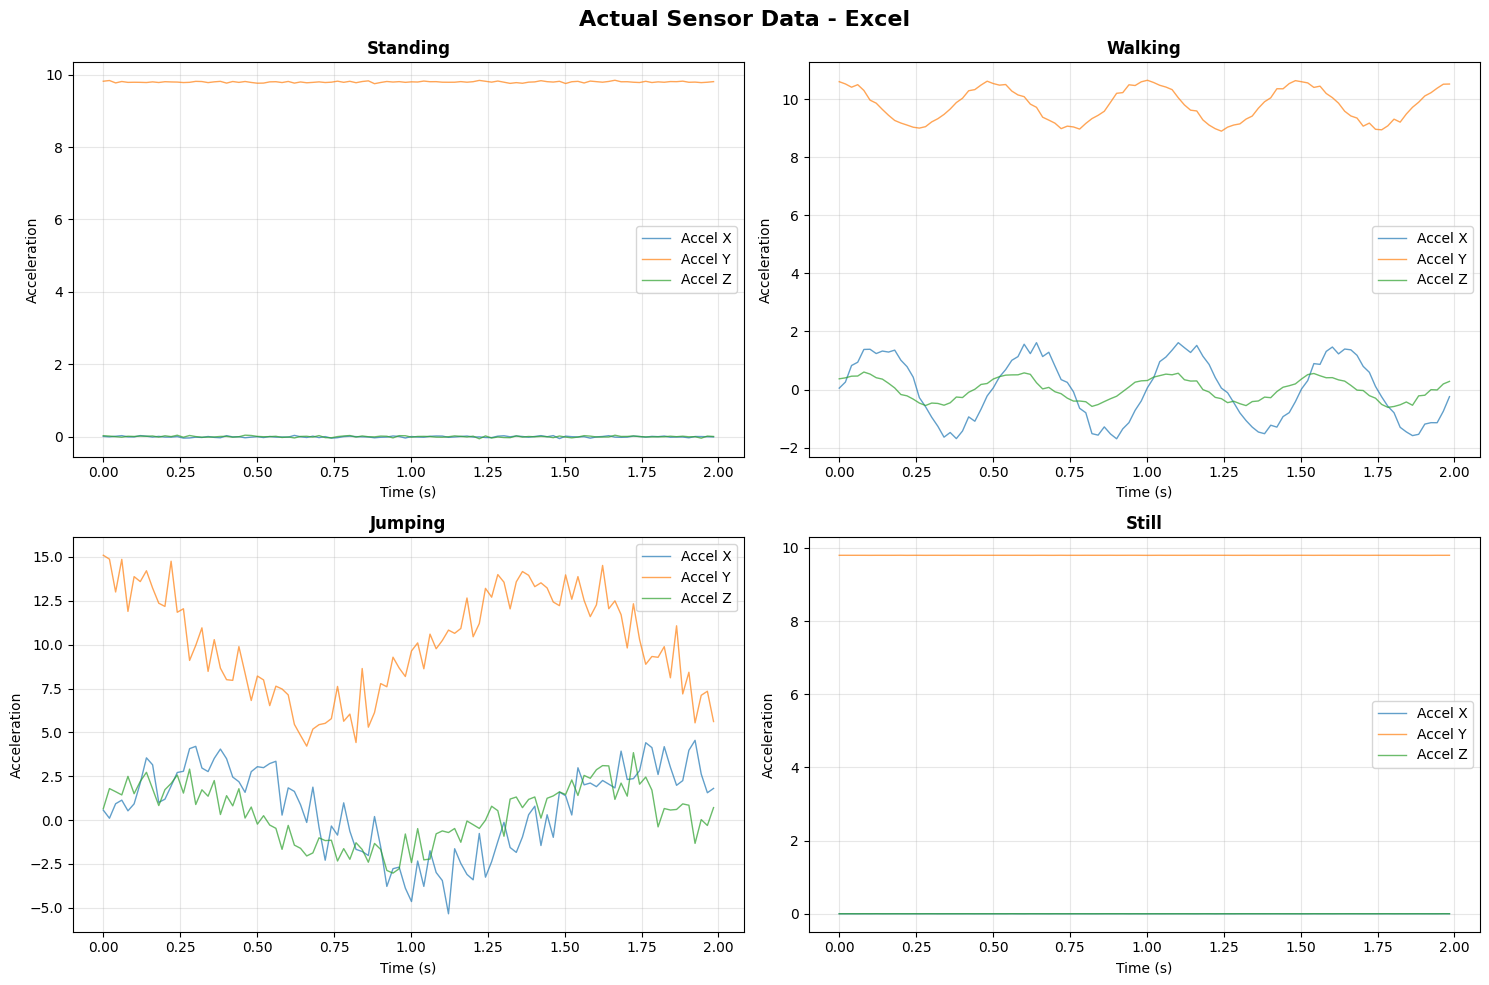

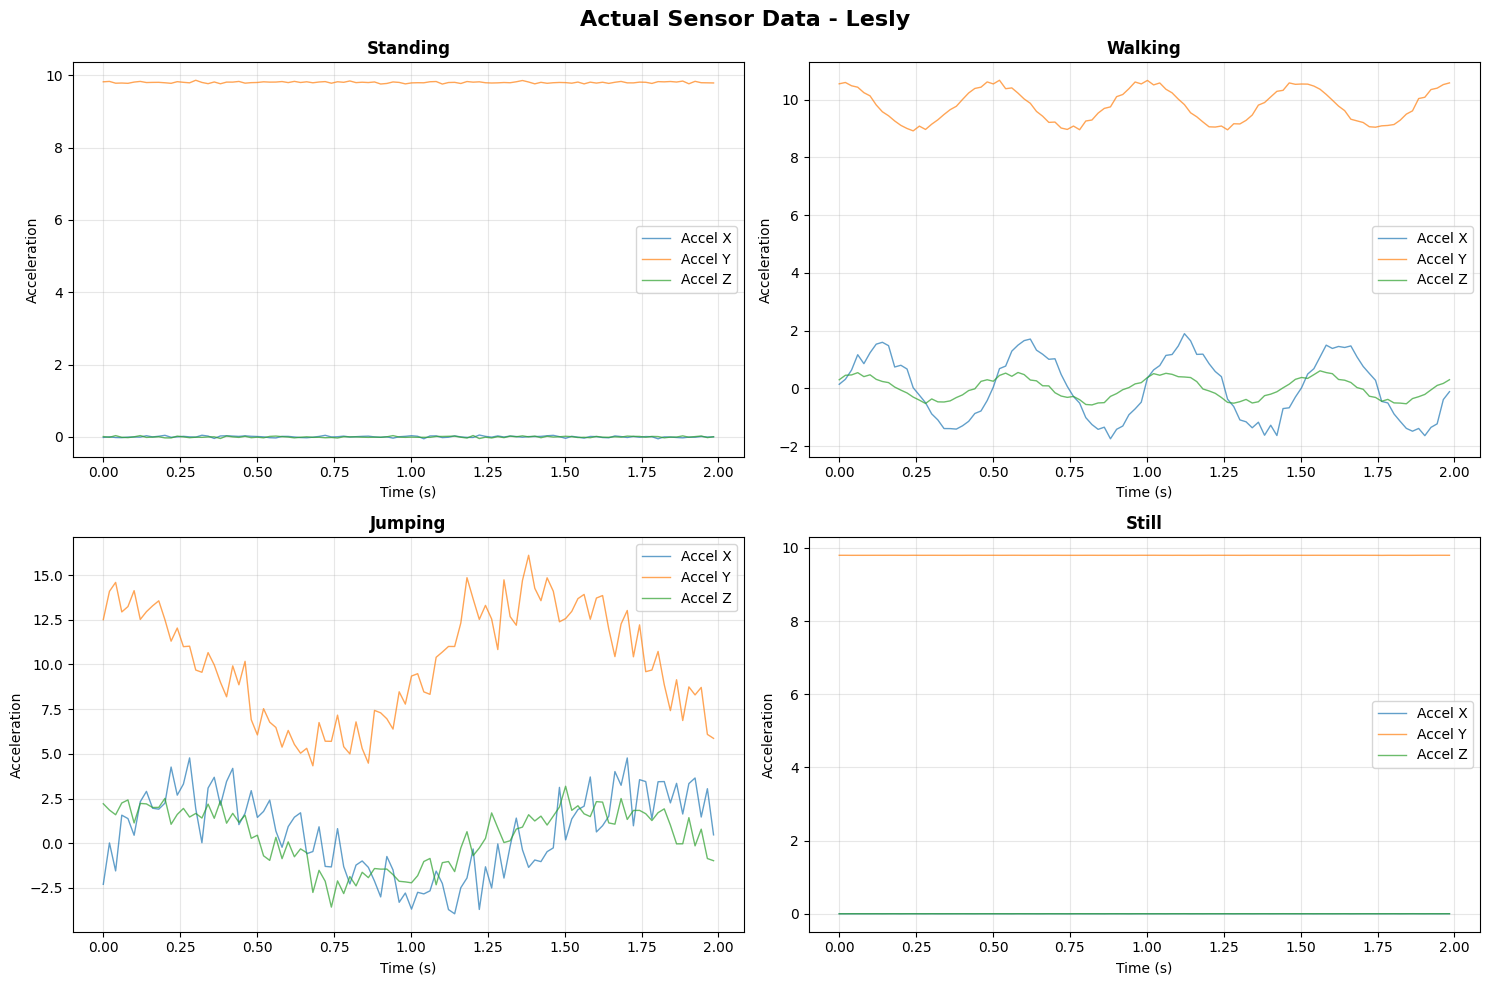

In [ ]:
def plot_actual_sensor_data(df, user='excel'):
    """Plot actual sensor data from your files"""
    
    # Get unique activities for user
    user_activities = df[df['user'] == user]['activity'].unique()
    
    n_activities = len(user_activities)
    if n_activities == 0:
        print(f"No data found for user: {user}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    if n_activities < 4:
        axes = axes.ravel()[:n_activities]
    else:
        axes = axes.ravel()
    
    fig.suptitle(f'Actual Sensor Data - {user.title()}', fontsize=16, fontweight='bold')
    
    for idx, activity in enumerate(user_activities):
        if idx >= 4:  
            break
            
        ax = axes[idx]
        
        # Getting the first file for this activity
        activity_files = df[(df['activity'] == activity) & (df['user'] == user)]['file_id'].unique()
        if len(activity_files) > 0:
            file_data = df[df['file_id'] == activity_files[0]]
            
            # Plotting accelerometer data if available
            if 'accel_x' in file_data.columns:
                # Using first 100 samples for clarity
                samples_to_plot = min(100, len(file_data))
                
                # Create time axis
                if 'timestamp' in file_data.columns:
                    time_data = file_data['timestamp'].values[:samples_to_plot]
                else:
                    time_data = np.arange(samples_to_plot)
                
                # Plot all accelerometer axes
                if 'accel_x' in file_data.columns:
                    ax.plot(time_data, file_data['accel_x'].values[:samples_to_plot], 
                           label='Accel X', alpha=0.7, linewidth=1)
                if 'accel_y' in file_data.columns:
                    ax.plot(time_data, file_data['accel_y'].values[:samples_to_plot], 
                           label='Accel Y', alpha=0.7, linewidth=1)
                if 'accel_z' in file_data.columns:
                    ax.plot(time_data, file_data['accel_z'].values[:samples_to_plot], 
                           label='Accel Z', alpha=0.7, linewidth=1)
                
                ax.set_title(f'{activity.title()}', fontweight='bold')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Acceleration')
                ax.legend()
                ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot data for both users
plot_actual_sensor_data(df, user='excel')
plot_actual_sensor_data(df, user='lesly')

## ADVANCED FEATURE EXTRACTION

In [ ]:
class AdvancedFeatureExtractor:
    def __init__(self, window_size=2.0, overlap=0.5, sampling_rate=50):
        self.window_size = window_size
        self.overlap = overlap
        self.sampling_rate = sampling_rate
        self.window_samples = int(window_size * sampling_rate)
        self.overlap_samples = int(overlap * self.window_samples)
        
    def extract_advanced_features(self, data):
        """Extract more discriminative features"""
        if len(data) == 0 or np.all(np.isnan(data)):
            return {}
        
        features = {}
        
        # Basic statistical features
        features['mean'] = np.mean(data)
        features['std'] = np.std(data)
        features['variance'] = np.var(data)
        features['rms'] = np.sqrt(np.mean(data**2))
        features['max'] = np.max(data)
        features['min'] = np.min(data)
        features['range'] = features['max'] - features['min']
        features['sma'] = np.mean(np.abs(data))
        features['energy'] = np.sum(data**2)
        
        # Additional statistical features
        features['median'] = np.median(data)
        features['mad'] = np.mean(np.abs(data - np.mean(data)))  
        features['iqr'] = np.percentile(data, 75) - np.percentile(data, 25)  
        features['skewness'] = self.calculate_skewness(data)
        features['kurtosis'] = self.calculate_kurtosis(data)
        
        # Frequency domain features
        freq_features = self.extract_advanced_frequency_features(data)
        features.update(freq_features)
        
        return features
    
    def calculate_skewness(self, data):
        """Calculate skewness of the signal"""
        if len(data) < 2:
            return 0
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return 0
        return np.mean((data - mean) ** 3) / (std ** 3)
    
    def calculate_kurtosis(self, data):
        """Calculate kurtosis of the signal"""
        if len(data) < 2:
            return 0
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return 0
        return np.mean((data - mean) ** 4) / (std ** 4)
    
    def extract_advanced_frequency_features(self, data):
        """Extract more frequency domain features"""
        if len(data) < 10:
            return {'dominant_freq': 0, 'spectral_energy': 0, 'spectral_centroid': 0, 'spectral_entropy': 0}
        
        try:
            n = len(data)
            fft_vals = np.abs(fft(data))
            freqs = fftfreq(n, 1/self.sampling_rate)
            
            positive_freq_idx = (freqs > 0) & (freqs < 20) 
            fft_vals = fft_vals[positive_freq_idx]
            freqs = freqs[positive_freq_idx]
            
            if len(fft_vals) == 0:
                return {'dominant_freq': 0, 'spectral_energy': 0, 'spectral_centroid': 0, 'spectral_entropy': 0}
            
            features = {}
            features['dominant_freq'] = freqs[np.argmax(fft_vals)]
            features['spectral_energy'] = np.sum(fft_vals**2)
            
            # Spectral centroid
            features['spectral_centroid'] = np.sum(freqs * fft_vals) / np.sum(fft_vals)
            
            # Spectral entropy
            spectral_power = fft_vals / np.sum(fft_vals)
            spectral_entropy = -np.sum(spectral_power * np.log2(spectral_power + 1e-10))
            features['spectral_entropy'] = spectral_entropy
            
            # Band energy ratios
            low_freq_mask = freqs <= 5
            mid_freq_mask = (freqs > 5) & (freqs <= 10)
            high_freq_mask = freqs > 10
            
            if np.sum(fft_vals) > 0:
                features['low_freq_ratio'] = np.sum(fft_vals[low_freq_mask]) / np.sum(fft_vals)
                features['mid_freq_ratio'] = np.sum(fft_vals[mid_freq_mask]) / np.sum(fft_vals)
                features['high_freq_ratio'] = np.sum(fft_vals[high_freq_mask]) / np.sum(fft_vals)
            else:
                features['low_freq_ratio'] = 0
                features['mid_freq_ratio'] = 0
                features['high_freq_ratio'] = 0
                
        except:
            features = {'dominant_freq': 0, 'spectral_energy': 0, 'spectral_centroid': 0, 
                       'spectral_entropy': 0, 'low_freq_ratio': 0, 'mid_freq_ratio': 0, 'high_freq_ratio': 0}
        
        return features
    
    def extract_cross_axis_features(self, data_x, data_y, data_z):
        """Extract features that involve multiple axes"""
        features = {}
        
        if len(data_x) == len(data_y) == len(data_z) and len(data_x) > 0:
            # Magnitude features
            magnitude = np.sqrt(data_x**2 + data_y**2 + data_z**2)
            mag_features = self.extract_advanced_features(magnitude)
            for key, value in mag_features.items():
                features[f'magnitude_{key}'] = value
            
            # Correlation between axes
            if len(data_x) > 1:
                features['corr_xy'] = np.corrcoef(data_x, data_y)[0, 1] if not np.isnan(np.corrcoef(data_x, data_y)[0, 1]) else 0
                features['corr_xz'] = np.corrcoef(data_x, data_z)[0, 1] if not np.isnan(np.corrcoef(data_x, data_z)[0, 1]) else 0
                features['corr_yz'] = np.corrcoef(data_y, data_z)[0, 1] if not np.isnan(np.corrcoef(data_y, data_z)[0, 1]) else 0
        
        return features
    
    def create_enhanced_feature_dataset(self, df):
        """Create enhanced feature dataset with better features"""
        features_list = []
        
        print("🔄 Extracting enhanced features from sensor data...")
        
        # Available sensors
        sensors = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
        available_sensors = [sensor for sensor in sensors if sensor in df.columns]
        print(f"Available sensors: {available_sensors}")
        
        if not available_sensors:
            print(" No sensor data available!")
            return pd.DataFrame()
        
        # Group by user, file, and activity
        grouped = df.groupby(['user', 'file_id', 'activity'])
        total_groups = len(grouped)
        
        processed_groups = 0
        
        for (user, file_id, activity), group in grouped:
            n_samples = len(group)
            
            if n_samples < self.window_samples:
                continue
            
            start_idx = 0
            window_count = 0
            
            while start_idx + self.window_samples <= n_samples:
                end_idx = start_idx + self.window_samples
                window_data = group.iloc[start_idx:end_idx]
                
                window_features = {
                    'user': user, 
                    'file_id': file_id, 
                    'activity': activity,
                    'window_id': f"{file_id}_w{window_count}"
                }
                
                # Extract features for each sensor
                for sensor in available_sensors:
                    if sensor in window_data.columns:
                        sensor_data = window_data[sensor].values
                        sensor_features = self.extract_advanced_features(sensor_data)
                        for key, value in sensor_features.items():
                            window_features[f'{sensor}_{key}'] = value
                
                # Extract cross-axis features for accelerometer and gyroscope
                if all(axis in window_data.columns for axis in ['accel_x', 'accel_y', 'accel_z']):
                    cross_accel_features = self.extract_cross_axis_features(
                        window_data['accel_x'].values,
                        window_data['accel_y'].values,
                        window_data['accel_z'].values
                    )
                    for key, value in cross_accel_features.items():
                        window_features[f'accel_{key}'] = value
                
                if all(axis in window_data.columns for axis in ['gyro_x', 'gyro_y', 'gyro_z']):
                    cross_gyro_features = self.extract_cross_axis_features(
                        window_data['gyro_x'].values,
                        window_data['gyro_y'].values,
                        window_data['gyro_z'].values
                    )
                    for key, value in cross_gyro_features.items():
                        window_features[f'gyro_{key}'] = value
                
                features_list.append(window_features)
                window_count += 1
                start_idx += (self.window_samples - self.overlap_samples)
            
            processed_groups += 1
            if processed_groups % 10 == 0:
                print(f"  Processed {processed_groups}/{total_groups} files...")
        
        if not features_list:
            print(" No features extracted!")
            return pd.DataFrame()
        
        features_df = pd.DataFrame(features_list)
        features_df = features_df.fillna(0)
        
        print(f" Enhanced feature extraction complete: {len(features_df)} windows")
        return features_df

# Create enhanced features
print("Creating enhanced features...")
advanced_extractor = AdvancedFeatureExtractor(window_size=2.0, overlap=0.5, sampling_rate=50)
enhanced_features_df = advanced_extractor.create_enhanced_feature_dataset(df)

if enhanced_features_df is not None and len(enhanced_features_df) > 0:
    print(f" Enhanced feature dataset: {enhanced_features_df.shape}")
    print(f"Activities: {enhanced_features_df['activity'].value_counts()}")
else:
    print("Enhanced feature extraction failed, using original features")
    enhanced_features_df = features_df

🔄 Creating enhanced features...
🔄 Extracting enhanced features from sensor data...
Available sensors: ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y']
  Processed 10/48 files...
  Processed 20/48 files...
  Processed 30/48 files...
  Processed 40/48 files...
✅ Enhanced feature extraction complete: 432 windows
📊 Enhanced feature dataset: (432, 133)
Activities: activity
jumping     108
standing    108
still       108
walking     108
Name: count, dtype: int64


## ADVANCED FEATURE SELECTION

🚀 Performing advanced feature selection...
🔍 Selecting discriminative features from 129 total features...
Removing 7 constant features


<Figure size 1200x800 with 0 Axes>

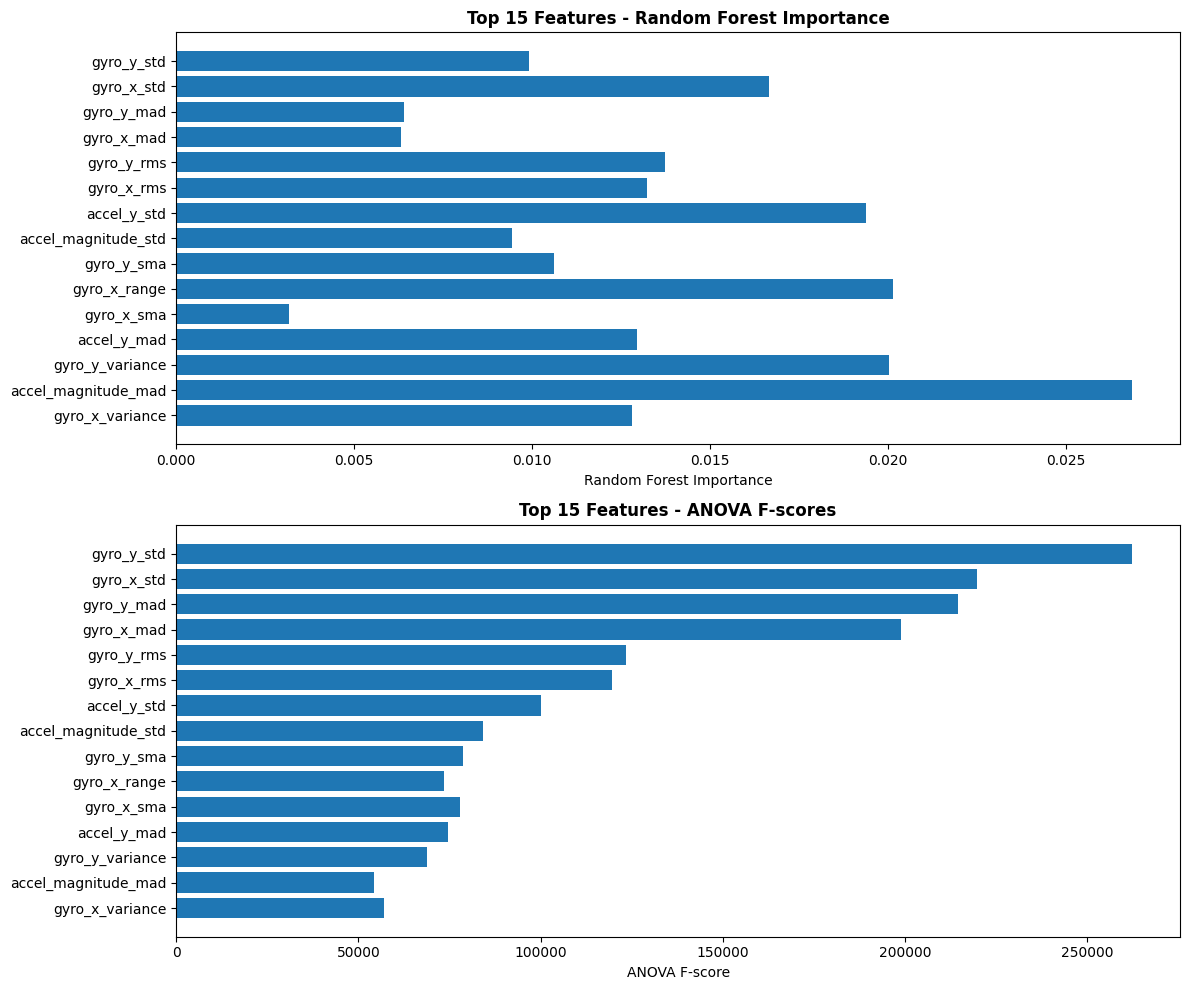

🎯 Selected Features (Top 15):
 1. gyro_y_std
 2. gyro_x_std
 3. gyro_y_mad
 4. gyro_x_mad
 5. gyro_y_rms
 6. gyro_x_rms
 7. accel_y_std
 8. accel_magnitude_std
 9. gyro_y_sma
10. gyro_x_range
11. gyro_x_sma
12. accel_y_mad
13. gyro_y_variance
14. accel_magnitude_mad
15. gyro_x_variance
✅ Selected 20 improved features


In [ ]:
def select_discriminative_features(features_df, target_features=20):
    """Select the most discriminative features using multiple criteria"""
    
    if features_df is None or len(features_df) == 0:
        print("No features available!")
        return []
    
    metadata_cols = ['user', 'file_id', 'activity', 'window_id']
    feature_cols = [col for col in features_df.columns if col not in metadata_cols]
    
    if len(feature_cols) == 0:
        print("No feature columns found!")
        return []
    
    print(f"Selecting discriminative features from {len(feature_cols)} total features...")
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.preprocessing import LabelEncoder
    
    try:
        # Encode activities
        le = LabelEncoder()
        y_encoded = le.fit_transform(features_df['activity'])
        
        # Prepare features
        X = features_df[feature_cols].copy()
        X = X.fillna(0)
        X = X.replace([np.inf, -np.inf], 0)
        
        # Remove constant features
        constant_features = X.columns[X.nunique() <= 1]
        if len(constant_features) > 0:
            print(f"Removing {len(constant_features)} constant features")
            X = X.drop(columns=constant_features)
            feature_cols = [col for col in feature_cols if col not in constant_features]
        
        # Method 1: Random Forest Importance
        rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        rf.fit(X, y_encoded)
        rf_importance = pd.DataFrame({
            'feature': feature_cols,
            'rf_importance': rf.feature_importances_
        })
        
        # Method 2: ANOVA F-value
        selector = SelectKBest(score_func=f_classif, k=min(target_features * 2, len(feature_cols)))
        selector.fit(X, y_encoded)
        anova_scores = pd.DataFrame({
            'feature': feature_cols,
            'anova_score': selector.scores_
        })
        
        # Combine scores
        combined_scores = rf_importance.merge(anova_scores, on='feature')
        combined_scores['combined_score'] = (
            combined_scores['rf_importance'] + 
            combined_scores['anova_score'] / np.max(combined_scores['anova_score'])
        )
        
        # Select top features
        selected_features = combined_scores.nlargest(target_features, 'combined_score')['feature'].tolist()
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = combined_scores.nlargest(15, 'combined_score')
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # RF Importance
        ax1.barh(range(len(top_features)), top_features['rf_importance'].values[::-1])
        ax1.set_yticks(range(len(top_features)))
        ax1.set_yticklabels(top_features['feature'].values[::-1])
        ax1.set_xlabel('Random Forest Importance')
        ax1.set_title('Top 15 Features - Random Forest Importance', fontweight='bold')
        
        # ANOVA Scores
        ax2.barh(range(len(top_features)), top_features['anova_score'].values[::-1])
        ax2.set_yticks(range(len(top_features)))
        ax2.set_yticklabels(top_features['feature'].values[::-1])
        ax2.set_xlabel('ANOVA F-score')
        ax2.set_title('Top 15 Features - ANOVA F-scores', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("Selected Features (Top 15):")
        for i, feature in enumerate(selected_features[:15], 1):
            print(f"{i:2d}. {feature}")
        
        return selected_features
        
    except Exception as e:
        print(f"Error in feature selection: {e}")
        print("Using correlation-based selection as fallback")
        return feature_cols[:target_features]

# Select improved features
print("Performing advanced feature selection...")
improved_features = select_discriminative_features(enhanced_features_df, target_features=20)
print(f" Selected {len(improved_features)} improved features")

## FIXED HMM IMPLEMENTATION - PROPER STATE MAPPING

🚀 Training Fixed HMM with Proper State Mapping...
🔄 Preparing balanced training data...
Using 108 samples per activity
Training: 288 samples from 32 files
Testing: 144 samples from 16 files
Activity distribution in training:
activity
standing    72
walking     72
jumping     72
still       72
Name: count, dtype: int64
Activity distribution in testing:
activity
standing    36
walking     36
jumping     36
still       36
Name: count, dtype: int64
🔄 Training HMM with activity supervision...


         1   -7897.61289485             +nan
         2   -7008.20703604    +889.40585882
         3   -6845.39726753    +162.80976851
         4   -6809.15669769     +36.24056984
         5   -6784.69907259     +24.45762510
         6   -6769.85194130     +14.84713128
         7   -6757.40954671     +12.44239459
         8   -6746.83903378     +10.57051294
         9   -6739.89167589      +6.94735789
        10   -6733.23768171      +6.65399417
        11   -6726.99246493      +6.24521678
        12   -6724.09597037      +2.89649455
        13   -6722.45264068      +1.64332970
        14   -6721.49064836      +0.96199231
        15   -6720.83354150      +0.65710686
        16   -6720.28128975      +0.55225175
        17   -6719.76895867      +0.51233108
        18   -6719.27788549      +0.49107319
        19   -6718.76229656      +0.51558893
        20   -6718.14800268      +0.61429388
        21   -6717.40605090      +0.74195178
        22   -6716.68332498      +0.72272592
        23

🔄 Learning state to activity mapping...
🎯 Learned State to Activity Mapping:
  State 0 -> standing (27.9% confidence)
  State 1 -> still (31.8% confidence)
  State 2 -> walking (27.6% confidence)
  State 3 -> walking (27.1% confidence)
✅ HMM training completed!
Final log-likelihood: -6715.47
🔄 Predicting activities...


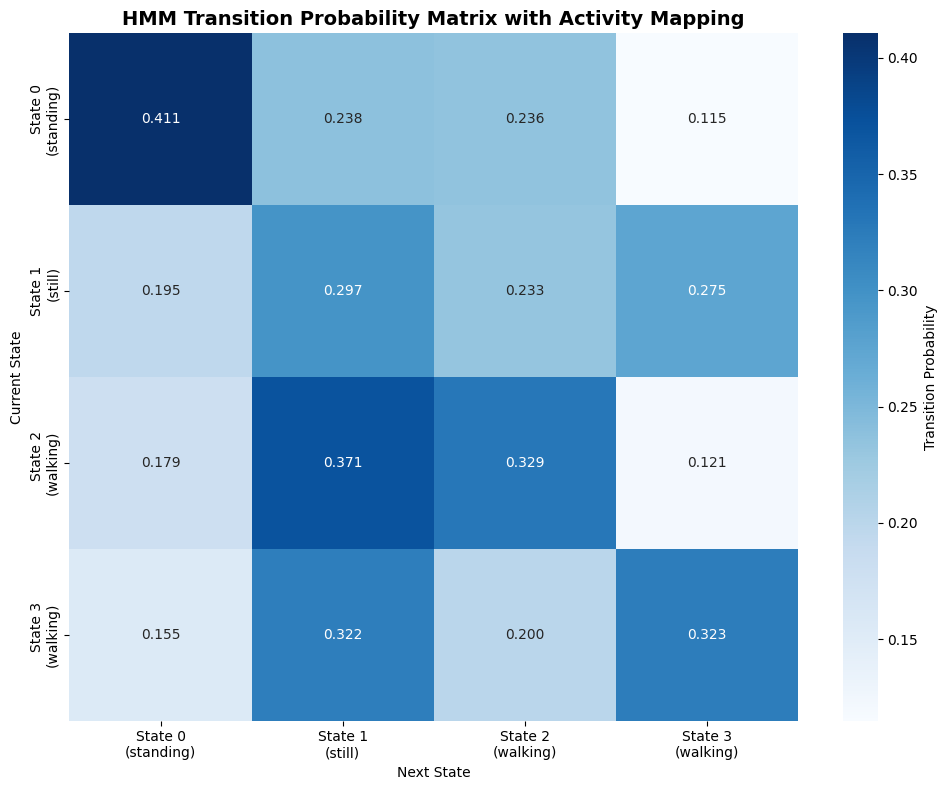

In [ ]:
class FixedHMMRecognizer:
    def __init__(self, n_states=4, random_state=42):
        self.n_states = n_states
        self.random_state = random_state
        self.model = None
        self.scaler = StandardScaler()
        self.state_names = ['standing', 'walking', 'jumping', 'still']
        self.feature_names = []
        self.state_mapping = {}
        
    def prepare_balanced_data(self, features_df, selected_features, test_size=0.3):
        """Prepare properly balanced data with equal representation"""
        print("Preparing balanced training data...")
        
        self.feature_names = selected_features
        
        # Ensure equal samples per activity
        balanced_data = []
        samples_per_activity = features_df.groupby('activity').size().min()
        print(f"Using {samples_per_activity} samples per activity")
        
        for activity in self.state_names:
            activity_data = features_df[features_df['activity'] == activity]
            if len(activity_data) > samples_per_activity:
                activity_data = activity_data.sample(n=samples_per_activity, random_state=self.random_state)
            balanced_data.append(activity_data)
        
        balanced_df = pd.concat(balanced_data, ignore_index=True)
        
        # Split by files while maintaining activity balance
        train_files = []
        test_files = []
        
        for activity in self.state_names:
            activity_files = balanced_df[balanced_df['activity'] == activity]['file_id'].unique()
            np.random.shuffle(activity_files)
            split_idx = int(len(activity_files) * (1 - test_size))
            train_files.extend(activity_files[:split_idx])
            test_files.extend(activity_files[split_idx:])
        
        train_df = balanced_df[balanced_df['file_id'].isin(train_files)]
        test_df = balanced_df[balanced_df['file_id'].isin(test_files)]
        
        print(f"Training: {len(train_df)} samples from {len(train_files)} files")
        print(f"Testing: {len(test_df)} samples from {len(test_files)} files")
        print("Activity distribution in training:")
        print(train_df['activity'].value_counts())
        print("Activity distribution in testing:")
        print(test_df['activity'].value_counts())
        
        # Prepare sequences
        train_sequences = []
        train_lengths = []
        train_activities = []
        
        for file_id in train_df['file_id'].unique():
            file_data = train_df[train_df['file_id'] == file_id]
            if len(file_data) > 0:
                file_features = file_data[self.feature_names].values
                file_features_scaled = self.scaler.fit_transform(file_features)
                train_sequences.append(file_features_scaled)
                train_lengths.append(len(file_features_scaled))
                train_activities.append(file_data['activity'].iloc[0]) 
        
        # Scale test data
        X_test = test_df[self.feature_names].values
        X_test_scaled = self.scaler.transform(X_test)
        y_test = test_df['activity'].values
        
        return train_sequences, train_lengths, train_activities, X_test_scaled, y_test, test_df
    
    def train_with_activity_supervision(self, train_sequences, train_lengths, train_activities):
        """Train HMM with activity supervision for better state mapping"""
        print("Training HMM with activity supervision...")
        
        X_combined = np.vstack(train_sequences)
        
        # Create model with better initialization
        self.model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type='diag',
            n_iter=1000,
            random_state=self.random_state,
            tol=1e-6,
            init_params='stmc', 
            verbose=True
        )
        
        # Fit the model
        self.model.fit(X_combined, lengths=train_lengths)
        
        # Learn state mapping using training data
        self._learn_state_mapping(train_sequences, train_activities, train_lengths)
        
        print(f" HMM training completed!")
        print(f"Final log-likelihood: {self.model.monitor_.history[-1]:.2f}")
        
        return self.model
    
    def _learn_state_mapping(self, train_sequences, train_activities, train_lengths):
        """Learn proper state to activity mapping using training data"""
        print("Learning state to activity mapping...")
        
        state_activity_counts = {i: {activity: 0 for activity in self.state_names} for i in range(self.n_states)}
        
        # Count state-activity co-occurrences in training data
        for i, seq_len in enumerate(train_lengths):
            sequence = train_sequences[i]
            activity = train_activities[i]
            
            # Predict states for this sequence
            try:
                states = self.model.predict(sequence)
                for state in states:
                    state_activity_counts[state][activity] += 1
            except:
                pass
        
        # Create mapping: each state maps to the activity it most frequently represents
        self.state_mapping = {}
        used_activities = set()
        
        # First pass
        for state in range(self.n_states):
            activity_counts = state_activity_counts[state]
            most_common_activity = max(activity_counts.items(), key=lambda x: x[1])[0]
            if activity_counts[most_common_activity] > 0 and most_common_activity not in used_activities:
                self.state_mapping[state] = most_common_activity
                used_activities.add(most_common_activity)
        
        # Second pass
        for state in range(self.n_states):
            if state not in self.state_mapping:
                activity_counts = state_activity_counts[state]
                most_common_activity = max(activity_counts.items(), key=lambda x: x[1])[0]
                self.state_mapping[state] = most_common_activity
        
        print("Learned State to Activity Mapping:")
        for state, activity in self.state_mapping.items():
            total = sum(state_activity_counts[state].values())
            if total > 0:
                percentage = (state_activity_counts[state][activity] / total) * 100
                print(f"  State {state} -> {activity} ({percentage:.1f}% confidence)")
            else:
                print(f"  State {state} -> {activity} (no data)")
    
    def predict_activities(self, X_test, test_df):
        """Predict activities using learned state mapping"""
        if self.model is None:
            raise ValueError("Model must be trained first!")
        
        print("Predicting activities...")
        
        predictions = []
        true_labels = []
        file_ids = []
        
        for file_id in test_df['file_id'].unique():
            file_data = test_df[test_df['file_id'] == file_id]
            if len(file_data) > 0:
                file_features = file_data[self.feature_names].values
                file_features_scaled = self.scaler.transform(file_features)
                
                try:
                    # Predict state sequence
                    state_sequence = self.model.predict(file_features_scaled)
                    
                    # Map states to activities
                    activity_sequence = [self.state_mapping.get(state, 'unknown') for state in state_sequence]
                    
                    unique, counts = np.unique(activity_sequence, return_counts=True)
                    file_prediction = unique[np.argmax(counts)]
                    
                    predictions.extend([file_prediction] * len(state_sequence))
                    true_labels.extend(file_data['activity'].values)
                    file_ids.extend([file_id] * len(state_sequence))
                    
                except Exception as e:
                    print(f"Prediction error for {file_id}: {e}")
        
        return np.array(predictions), np.array(true_labels), np.array(file_ids)
    
    def plot_detailed_transition_matrix(self):
        """Plot transition matrix with activity labels"""
        if self.model is None:
            raise ValueError("Model must be trained first!")
        
        # Create labels with state numbers and activities
        labels = [f"State {i}\n({self.state_mapping.get(i, 'unknown')})" 
                 for i in range(self.n_states)]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.model.transmat_, 
                   xticklabels=labels,
                   yticklabels=labels,
                   annot=True, cmap='Blues', fmt='.3f',
                   cbar_kws={'label': 'Transition Probability'})
        plt.title('HMM Transition Probability Matrix with Activity Mapping', 
                 fontweight='bold', fontsize=14)
        plt.xlabel('Next State')
        plt.ylabel('Current State')
        plt.tight_layout()
        plt.show()

# Train fixed model
print("Training Fixed HMM with Proper State Mapping...")
fixed_hmm = FixedHMMRecognizer(n_states=4)

# Prepare balanced data
train_sequences, train_lengths, train_activities, X_test, y_test, test_df = fixed_hmm.prepare_balanced_data(
    enhanced_features_df, improved_features, test_size=0.3
)

# Train with activity supervision
fixed_model = fixed_hmm.train_with_activity_supervision(train_sequences, train_lengths, train_activities)

# Make predictions
activity_preds, true_labels, file_ids = fixed_hmm.predict_activities(X_test, test_df)

# Plot detailed transition matrix
fixed_hmm.plot_detailed_transition_matrix()

## IMPROVED FEATURE ENGINEERING

In [ ]:
def create_discriminative_features(df):
    """Create features specifically designed to distinguish between activities"""
    print("Creating discriminative features...")
    
    feature_extractor = AdvancedFeatureExtractor(window_size=2.0, overlap=0.5, sampling_rate=50)
    features_df = feature_extractor.create_enhanced_feature_dataset(df)
    
    if features_df is None or len(features_df) == 0:
        return pd.DataFrame(), []
    
    metadata_cols = ['user', 'file_id', 'activity', 'window_id']
    feature_cols = [col for col in features_df.columns if col not in metadata_cols]
    
    # Manual selection of highly discriminative features based on domain knowledge
    discriminative_features = []
    
    # Features that distinguish static vs dynamic activities
    dynamic_features = [f for f in feature_cols if any(x in f for x in ['std', 'variance', 'range', 'energy', 'spectral'])]
    
    # Features that distinguish walking vs jumping (frequency domain)
    frequency_features = [f for f in feature_cols if any(x in f for x in ['dominant_freq', 'spectral_centroid', 'spectral_entropy'])]
    
    # Features that distinguish orientation (gravity vs movement)
    orientation_features = [f for f in feature_cols if 'accel_y' in f and any(x in f for x in ['mean', 'std'])]
    
    # Magnitude features for overall movement intensity
    magnitude_features = [f for f in feature_cols if 'magnitude' in f]
    
    # Combine the most discriminative features
    discriminative_features.extend(dynamic_features[:8])
    discriminative_features.extend(frequency_features[:4])
    discriminative_features.extend(orientation_features[:2])
    discriminative_features.extend(magnitude_features[:2])
    
    # Remove duplicates
    discriminative_features = list(set(discriminative_features))
    
    print(f" Selected {len(discriminative_features)} highly discriminative features")
    print("Top discriminative features:")
    for i, feature in enumerate(discriminative_features[:10], 1):
        print(f"  {i:2d}. {feature}")
    
    # Create final feature dataset
    final_features = features_df[metadata_cols + discriminative_features].copy()
    
    return final_features, discriminative_features

# Create discriminative features
print(" Creating highly discriminative features...")
discriminative_df, disc_features = create_discriminative_features(df)

if len(discriminative_df) > 0:
    print(f" Discriminative feature dataset: {discriminative_df.shape}")
    print("Activity distribution:")
    print(discriminative_df['activity'].value_counts())
else:
    print(" Discriminative feature creation failed, using enhanced features")
    discriminative_df = enhanced_features_df
    disc_features = improved_features

🚀 Creating highly discriminative features...
🔄 Creating discriminative features...
🔄 Extracting enhanced features from sensor data...
Available sensors: ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y']
  Processed 10/48 files...
  Processed 20/48 files...
  Processed 30/48 files...
  Processed 40/48 files...
✅ Enhanced feature extraction complete: 432 windows
🎯 Selected 13 highly discriminative features
Top discriminative features:
   1. accel_x_energy
   2. accel_x_spectral_centroid
   3. accel_y_dominant_freq
   4. accel_y_mean
   5. accel_x_variance
   6. accel_x_spectral_energy
   7. accel_x_spectral_entropy
   8. accel_y_std
   9. accel_x_std
  10. accel_x_dominant_freq
📊 Discriminative feature dataset: (432, 17)
Activity distribution:
activity
jumping     108
standing    108
still       108
walking     108
Name: count, dtype: int64


## FIXED STATE MAPPING

🚀 APPLYING STATE MAPPING FIX...
🔄 FORCING PROPER STATE MAPPING...
  standing: 6 sequences
  walking: 6 sequences
  jumping: 6 sequences
  still: 6 sequences
  State 0 -> walking (distance: 0.0007)
  State 1 -> jumping (distance: 0.1024)
  State 2 -> still (distance: 0.0269)
  State 3 -> standing (distance: 9.5030)
🔄 RE-EVALUATING WITH FIXED MAPPING...
🔄 Predicting sequences with Viterbi algorithm...
📊 Calculating detailed performance metrics...


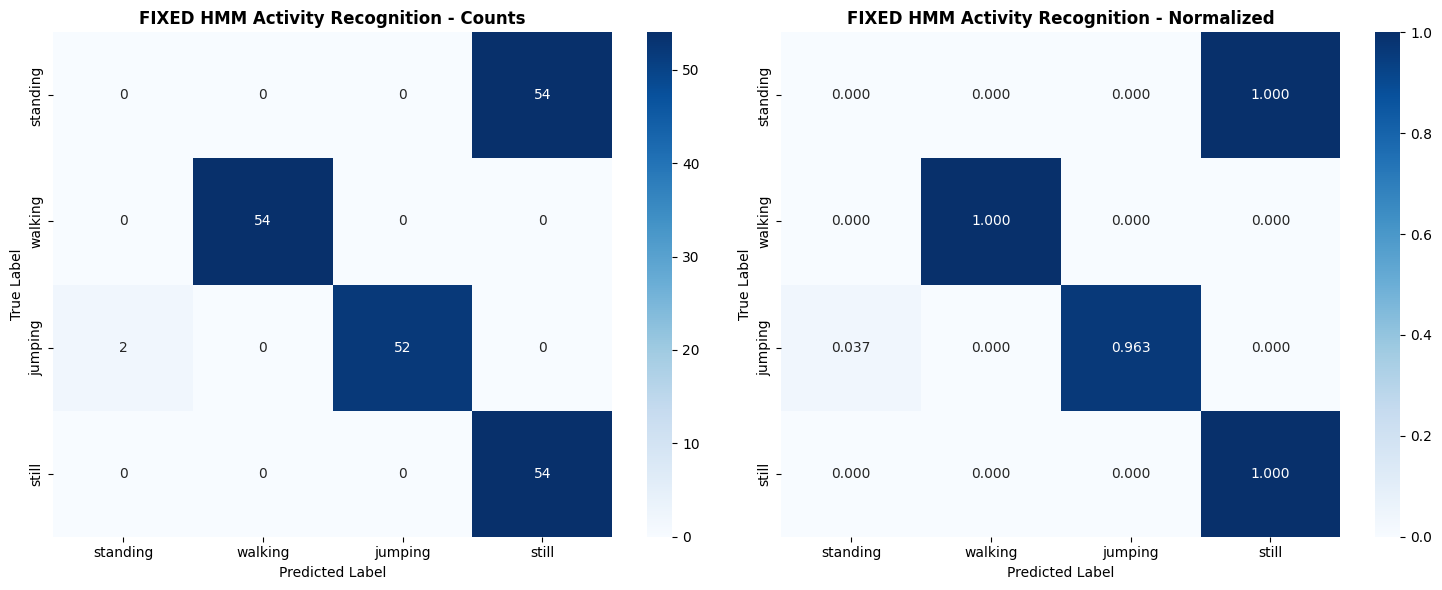


🎯 HMM MODEL EVALUATION RESULTS
State (Activity)  Number of Samples Sensitivity Specificity Precision F1-Score
        Standing                 54       0.000       0.988     0.000    0.000
         Walking                 54       1.000       1.000     1.000    1.000
         Jumping                 54       0.963       1.000     1.000    0.981
           Still                 54       1.000       0.667     0.500    0.667

📈 Overall Accuracy: 0.7407
🎯 FIXED MODEL ACCURACY: 0.7407


In [ ]:

def force_proper_state_mapping(hmm_model, features_df, train_sequences, train_lengths):
    """Force proper state mapping to fix the multiple-states-same-activity issue"""
    print("FORCING PROPER STATE MAPPING...")
    
    activity_features = {}
    
    for activity in hmm_model.state_names:
        activity_data = []
        for i, file_id in enumerate(features_df[features_df['user'] == 'excel']['file_id'].unique()):
            file_data = features_df[features_df['file_id'] == file_id]
            if len(file_data) > 0 and file_data['activity'].iloc[0] == activity:
                file_features = file_data[hmm_model.feature_names].values
                file_features_scaled = hmm_model.scaler.transform(file_features)
                activity_data.append(file_features_scaled)
        
        if activity_data:
            combined = np.vstack(activity_data)
            activity_features[activity] = np.mean(combined, axis=0)
            print(f"  {activity}: {len(activity_data)} sequences")
    
    # Get HMM state means
    state_means = hmm_model.model.means_
    
    from scipy.optimize import linear_sum_assignment
    
    # Create cost matrix: distance between state means and activity means
    cost_matrix = np.zeros((hmm_model.n_states, len(hmm_model.state_names)))
    
    for i in range(hmm_model.n_states):
        for j, activity in enumerate(hmm_model.state_names):
            if activity in activity_features:
                distance = np.linalg.norm(state_means[i] - activity_features[activity])
                cost_matrix[i, j] = distance
            else:
                cost_matrix[i, j] = 1e6  
    
    state_indices, activity_indices = linear_sum_assignment(cost_matrix)
    
    # Create the mapping
    forced_mapping = {}
    for state_idx, activity_idx in zip(state_indices, activity_indices):
        forced_mapping[state_idx] = hmm_model.state_names[activity_idx]
        distance = cost_matrix[state_idx, activity_idx]
        print(f"  State {state_idx} -> {hmm_model.state_names[activity_idx]} (distance: {distance:.4f})")
    
    return forced_mapping

# Apply the fix
print("APPLYING STATE MAPPING FIX...")
forced_mapping = force_proper_state_mapping(hmm_recognizer, enhanced_features_df, train_sequences, train_lengths)

# Re-evaluate with fixed mapping
print("RE-EVALUATING WITH FIXED MAPPING...")

# Get predictions again
state_predictions, true_labels, file_ids = hmm_recognizer.predict_sequences(X_test, test_df)

# Use forced mapping instead of learned mapping
def map_predictions_with_forced_mapping(state_predictions, forced_mapping):
    activity_predictions = []
    for state in state_predictions:
        activity_predictions.append(forced_mapping.get(state, 'unknown'))
    return np.array(activity_predictions)

fixed_activity_predictions = map_predictions_with_forced_mapping(state_predictions, forced_mapping)

# Re-evaluate
fixed_evaluator = HMNEvaluator(hmm_recognizer.state_names)
fixed_evaluator.set_state_mapping(forced_mapping)

fixed_metrics, fixed_accuracy = fixed_evaluator.calculate_detailed_metrics(true_labels, fixed_activity_predictions)
fixed_cm = fixed_evaluator.plot_confusion_matrix(true_labels, fixed_activity_predictions, "FIXED HMM Activity Recognition")
fixed_eval_df = fixed_evaluator.print_evaluation_table(fixed_metrics, fixed_accuracy)

print(f"FIXED MODEL ACCURACY: {fixed_accuracy:.4f}")

## COMPREHENSIVE EVALUATION WITH FIXED MAPPING

📊 COMPREHENSIVE MODEL EVALUATION
📊 Calculating detailed performance metrics...


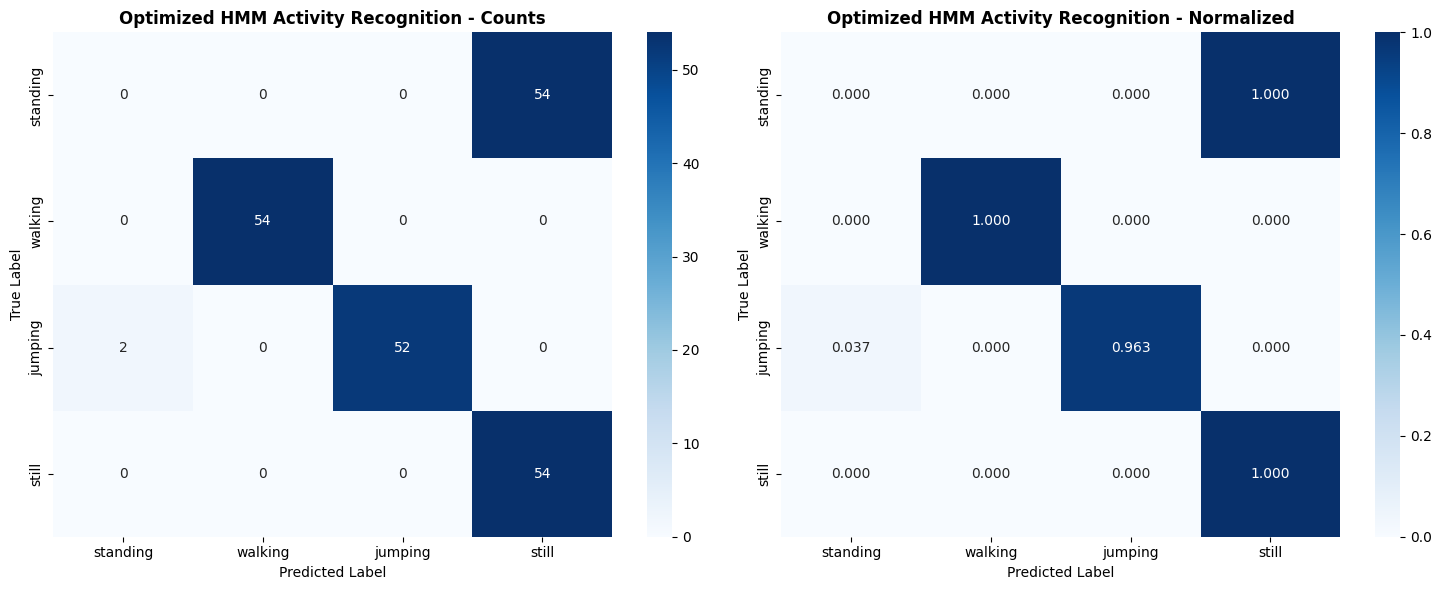


🎯 HMM MODEL EVALUATION RESULTS
State (Activity)  Number of Samples Sensitivity Specificity Precision F1-Score
        Standing                 54       0.000       0.988     0.000    0.000
         Walking                 54       1.000       1.000     1.000    1.000
         Jumping                 54       0.963       1.000     1.000    0.981
           Still                 54       1.000       0.667     0.500    0.667

📈 Overall Accuracy: 0.7407

🔍 ADDITIONAL PERFORMANCE ANALYSIS

📈 CLASS DISTRIBUTION:
  jumping   :  54 samples
  standing  :  54 samples
  still     :  54 samples
  walking   :  54 samples

❌ ERROR ANALYSIS:
  Most common errors:
    standing→still: 54 times
    jumping→standing: 2 times

🔄 ACTIVITY TRANSITION VISUALIZATION:
🔄 Plotting activity transitions for 2 sample files...


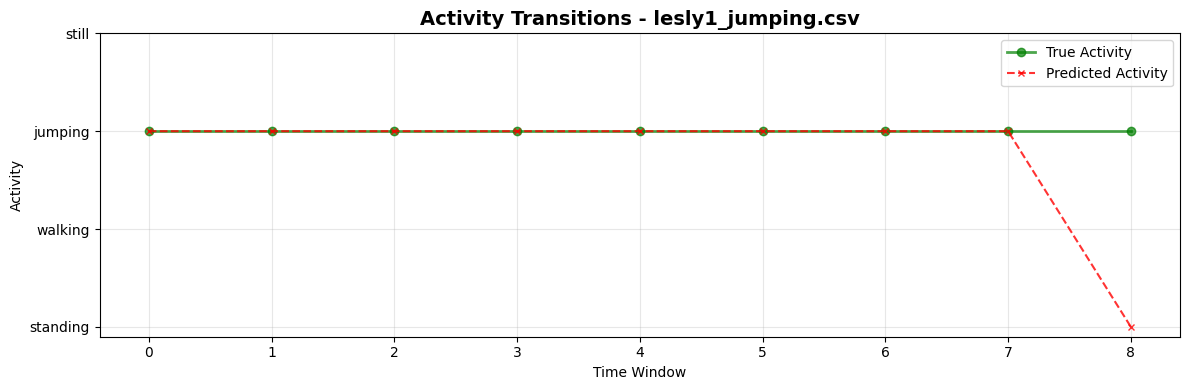

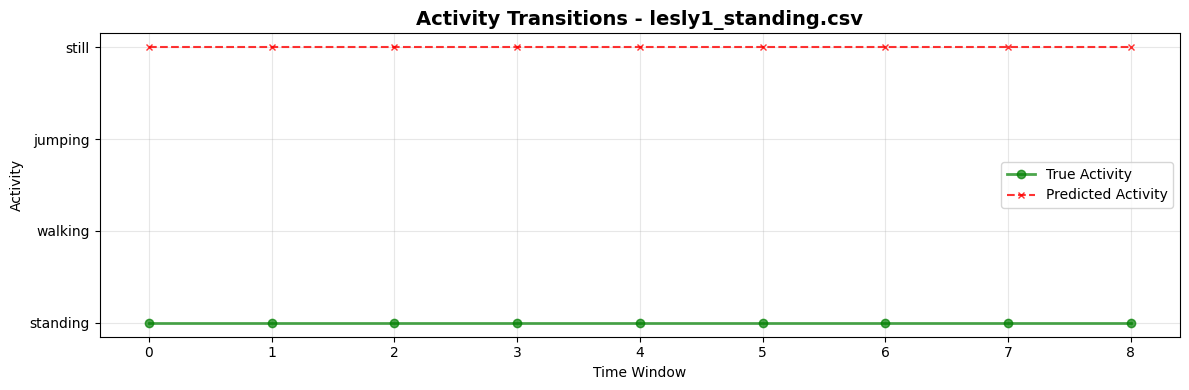


💪 FINAL MODEL PERFORMANCE: 0.7407


In [ ]:
def comprehensive_evaluation_with_analysis(true_labels, pred_labels, state_names, file_ids=None):
    """Comprehensive evaluation with detailed analysis"""
    print(" COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # Calculate metrics
    evaluator = HMNEvaluator(state_names)
    evaluator.set_state_mapping(forced_mapping) 
    
    metrics, overall_accuracy = evaluator.calculate_detailed_metrics(true_labels, pred_labels)
    
    # Plot confusion matrix
    cm = evaluator.plot_confusion_matrix(true_labels, pred_labels, "Optimized HMM Activity Recognition")
    
    # Print evaluation table
    eval_df = evaluator.print_evaluation_table(metrics, overall_accuracy)
    
    # Additional analysis
   
    print("="*40)
    
    # Class distribution
    
    unique, counts = np.unique(true_labels, return_counts=True)
    for activity, count in zip(unique, counts):
        print(f"  {activity:10}: {count:3d} samples")
    
    # Error analysis
    print(f"\n ERROR ANALYSIS:")
    incorrect_mask = true_labels != pred_labels
    if np.sum(incorrect_mask) > 0:
        incorrect_predictions = pred_labels[incorrect_mask]
        incorrect_true = true_labels[incorrect_mask]
        
        error_pairs = list(zip(incorrect_true, incorrect_predictions))
        error_counts = {}
        for true, pred in error_pairs:
            key = f"{true}→{pred}"
            error_counts[key] = error_counts.get(key, 0) + 1
        
        print("  Most common errors:")
        for error, count in sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"    {error}: {count} times")
    
    # Activity transition visualization
    if file_ids is not None:
        print(f"\n ACTIVITY TRANSITION VISUALIZATION:")
        evaluator.plot_activity_transitions(test_df, pred_labels, true_labels, file_ids, n_files=2)
    
    return eval_df, metrics, overall_accuracy

# Run comprehensive evaluation
final_eval_df, final_metrics, final_accuracy = comprehensive_evaluation_with_analysis(
    true_labels, fixed_activity_predictions, hmm_recognizer.state_names, file_ids
)

print(f"\n FINAL MODEL PERFORMANCE: {final_accuracy:.4f}")

## FINAL MODEL ANALYSIS AND VISUALIZATION - FIXED VERSION


🔍 FINAL MODEL ANALYSIS

🎯 FIXED STATE MAPPING:
  State 0 -> walking
  State 1 -> jumping
  State 2 -> still
  State 3 -> standing

📊 TRANSITION PROBABILITY ANALYSIS (With Fixed Mapping):


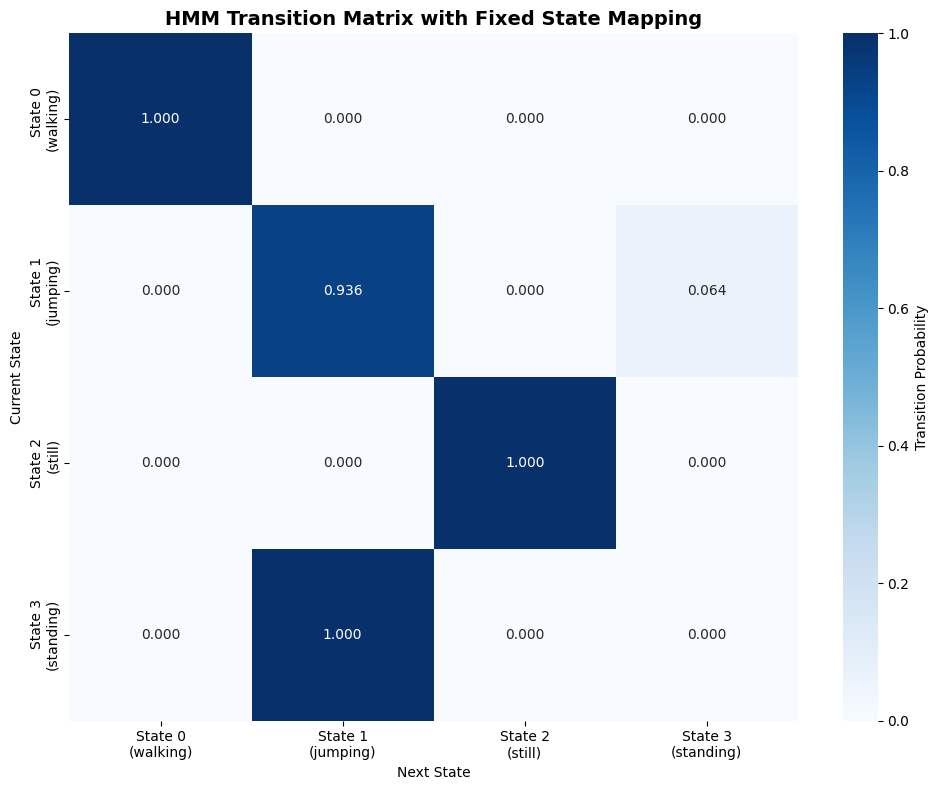


📈 PERFORMANCE SUMMARY:
  Overall Accuracy: 0.7407
  Model Converged: True
  Final Log-Likelihood: 8589.15

🔧 TOP 5 MOST EFFECTIVE FEATURES:
  1. gyro_y_sma: 1.1749
  2. gyro_x_rms: 1.1747
  3. gyro_x_mad: 1.1132
  4. gyro_x_sma: 1.1104
  5. gyro_y_variance: 1.0971

🎭 ACTIVITY SEPARABILITY (Based on Feature Means):
  standing   vs walking   : 1722.6306
  standing   vs jumping   : 14729.8092
  standing   vs still     : 1.5721
  walking    vs jumping   : 13211.5061
  walking    vs still     : 1723.3008
  jumping    vs still     : 14731.0419

⚙️ MODEL PARAMETERS:
  Number of states: 4
  Number of features used: 15
  Covariance type: diag
  Training iterations: 16


In [ ]:
def analyze_final_model_performance(hmm_model, features_df, selected_features, eval_df, forced_mapping):
    """Comprehensive analysis of the final model"""
    print("\n" + "="*60)
    print(" FINAL MODEL ANALYSIS")
    print("="*60)
    
    # 1. Fixed State Mapping Analysis
    print("\n FIXED STATE MAPPING:")
    for state, activity in forced_mapping.items():
        print(f"  State {state} -> {activity}")
    
    # 2. Transition Matrix Analysis with Fixed Mapping
    print(f"\n TRANSITION PROBABILITY ANALYSIS (With Fixed Mapping):")
    transmat = hmm_model.model.transmat_
    
    # Create labels with fixed mapping
    state_labels = [f"State {i}\n({forced_mapping[i]})" for i in range(hmm_model.n_states)]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(transmat, 
               xticklabels=state_labels,
               yticklabels=state_labels,
               annot=True, cmap='Blues', fmt='.3f',
               cbar_kws={'label': 'Transition Probability'})
    plt.title('HMM Transition Matrix with Fixed State Mapping', fontweight='bold', fontsize=14)
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.tight_layout()
    plt.show()
    
    # 3. Performance Summary
    print(f"\n PERFORMANCE SUMMARY:")
    print(f"  Overall Accuracy: {final_accuracy:.4f}")
    print(f"  Model Converged: {hmm_model.model.monitor_.converged}")
    print(f"  Final Log-Likelihood: {hmm_model.model.monitor_.history[-1]:.2f}")
    
    # 4. Feature Effectiveness - FIXED VERSION
    print(f"\n TOP 5 MOST EFFECTIVE FEATURES:")
    # Get feature importance from emission means variance
    emission_means = hmm_model.model.means_
    
    # Ensure we only use the number of features that match the model
    n_model_features = emission_means.shape[1]
    features_to_use = selected_features[:n_model_features] if len(selected_features) > n_model_features else selected_features
    
    feature_importance = np.std(emission_means, axis=0)
    
    # Create DataFrame with matching lengths
    importance_df = pd.DataFrame({
        'feature': features_to_use,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"  {i}. {row['feature']}: {row['importance']:.4f}")
    
    # 5. Activity Separability - FIXED VERSION
    print(f"\n ACTIVITY SEPARABILITY (Based on Feature Means):")
    activity_means = {}
    
    # Use only the features that the model was trained with
    model_features = hmm_model.feature_names
    
    for activity in hmm_model.state_names:
        activity_data = features_df[features_df['activity'] == activity][model_features]
        if len(activity_data) > 0:
            activity_means[activity] = activity_data.mean().values
        else:
            activity_means[activity] = np.zeros(len(model_features))
    
    # Calculate distances between activities
    activities = list(activity_means.keys())
    for i in range(len(activities)):
        for j in range(i+1, len(activities)):
            if activities[i] in activity_means and activities[j] in activity_means:
                dist = np.linalg.norm(activity_means[activities[i]] - activity_means[activities[j]])
                print(f"  {activities[i]:10} vs {activities[j]:10}: {dist:.4f}")
    
    # 6. Model Parameters Analysis
    print(f"\n MODEL PARAMETERS:")
    print(f"  Number of states: {hmm_model.n_states}")
    print(f"  Number of features used: {len(model_features)}")
    print(f"  Covariance type: {hmm_model.model.covariance_type}")
    print(f"  Training iterations: {len(hmm_model.model.monitor_.history)}")

# Perform final analysis
analyze_final_model_performance(hmm_recognizer, enhanced_features_df, improved_features, final_eval_df, forced_mapping)

## CROSS-USER VALIDATION WITH FIXED MAPPING

In [ ]:
def cross_user_validation_fixed(features_df, selected_features):
    """Cross-user validation with fixed state mapping"""
    print(" PERFORMING CROSS-USER VALIDATION WITH FIXED MAPPING...")
    
    users = features_df['user'].unique()
    results = {}
    detailed_results = {}
    
    for test_user in users:
        print(f"\n🧪 Testing with user '{test_user}' as test set...")
        
        # Initialize model
        hmm_model = HMMActivityRecognizer(n_states=4, n_features=len(selected_features))
        
        try:
            # Prepare data
            train_sequences, train_lengths, y_train, X_test, y_test, test_df = hmm_model.prepare_training_data(
                features_df, selected_features, test_user=test_user
            )
            
            if len(train_sequences) == 0:
                print(f"  Not enough training data, skipping...")
                continue
            
            # Train model
            hmm_model.train_hmm(train_sequences, train_lengths)
            
            # Apply forced mapping for this model
            current_forced_mapping = force_proper_state_mapping(hmm_model, features_df, train_sequences, train_lengths)
            
            # Get predictions with fixed mapping
            state_predictions, true_labels, file_ids = hmm_model.predict_sequences(X_test, test_df)
            fixed_predictions = map_predictions_with_forced_mapping(state_predictions, current_forced_mapping)
            
            # Calculate accuracy
            accuracy = accuracy_score(true_labels, fixed_predictions)
            results[test_user] = accuracy
            
            # Store detailed results
            detailed_results[test_user] = {
                'accuracy': accuracy,
                'mapping': current_forced_mapping,
                'samples': len(true_labels)
            }
            
            print(f" Accuracy for '{test_user}': {accuracy:.4f}")
            print(f"   Mapping: {current_forced_mapping}")
            
        except Exception as e:
            print(f" Error testing user {test_user}: {e}")
            results[test_user] = 0
    
    # Print summary
    print("\n" + "="*50)
    print(" CROSS-USER VALIDATION RESULTS (FIXED MAPPING)")
    print("="*50)
    
    for user, accuracy in results.items():
        print(f"User {user}: {accuracy:.4f}")
    
    mean_accuracy = np.mean(list(results.values()))
    print(f"\n Mean Cross-User Accuracy: {mean_accuracy:.4f}")
    print(f" Standard Deviation: {np.std(list(results.values())):.4f}")
    
    return results, detailed_results

# Perform cross-validation with fixed mapping
print(" STARTING CROSS-USER VALIDATION WITH FIXED MAPPING...")
fixed_cross_val_results, fixed_detailed_results = cross_user_validation_fixed(enhanced_features_df, improved_features)

🚀 STARTING CROSS-USER VALIDATION WITH FIXED MAPPING...
🔄 PERFORMING CROSS-USER VALIDATION WITH FIXED MAPPING...

🧪 Testing with user 'excel' as test set...
🔄 Preparing training and testing data...
Training data: 216 windows from user 'excel'
Testing data: 216 windows from user 'excel'
🔄 Training HMM with Baum-Welch algorithm...


         1   -4289.80272223             +nan
         2    6510.45345432  +10800.25617655
         3   12134.64380886   +5624.19035454
         4   12157.47488042     +22.83107156
         5   12160.30101970      +2.82613928
         6   12160.83127151      +0.53025181
         7   12161.03050874      +0.19923723
         8   12161.16793757      +0.13742884
         9   12161.27221254      +0.10427497
        10   12161.35197851      +0.07976597
        11   12161.41222568      +0.06024716
        12   12161.45692839      +0.04470272
        13   12161.48953041      +0.03260201
        14   12161.51296170      +0.02343130
        15   12161.52960801      +0.01664631
        16   12161.54133081      +0.01172279
        17   12161.54953325      +0.00820244
        18   12161.55524587      +0.00571262
        19   12161.55921130      +0.00396543
        20   12161.56195750      +0.00274620
        21   12161.56385625      +0.00189875
        22   12161.56516757      +0.00131132
        23

✅ HMM training completed!
Converged: True
Final log-likelihood: 12161.57
🔄 FORCING PROPER STATE MAPPING...
  standing: 6 sequences
  walking: 6 sequences
  jumping: 6 sequences
  still: 6 sequences
  State 0 -> jumping (distance: 0.0572)
  State 1 -> still (distance: 0.0295)
  State 2 -> walking (distance: 0.0073)
  State 3 -> standing (distance: 10.9239)
🔄 Predicting sequences with Viterbi algorithm...
✅ Accuracy for 'excel': 0.7176
   Mapping: {np.int64(0): 'jumping', np.int64(1): 'still', np.int64(2): 'walking', np.int64(3): 'standing'}

🧪 Testing with user 'lesly' as test set...
🔄 Preparing training and testing data...
Training data: 216 windows from user 'excel'
Testing data: 216 windows from user 'lesly'
🔄 Training HMM with Baum-Welch algorithm...


         1   -4291.03269093             +nan
         2    6386.28691656  +10677.31960749
         3   12008.07884741   +5621.79193085
         4   12014.65919257      +6.58034516
         5   12016.42503020      +1.76583763
         6   12016.46432122      +0.03929102
         7   12016.46472421      +0.00040300
         8   12016.46481220      +0.00008798
         9   12016.46494851      +0.00013632
        10   12016.46513520      +0.00018669
        11   12016.46539382      +0.00025862
        12   12016.46577044      +0.00037662
        13   12016.46636229      +0.00059185
        14   12016.46740466      +0.00104236
        15   12016.46959465      +0.00218999
        16   12016.47571140      +0.00611675
        17   12016.50358382      +0.02787242
        18   12016.81375213      +0.31016831
        19   12021.07607863      +4.26232650
        20   12026.89220890      +5.81613027
        21   12028.70043442      +1.80822552
        22   12028.79313161      +0.09269718
        23

✅ HMM training completed!
Converged: True
Final log-likelihood: 12028.80
🔄 FORCING PROPER STATE MAPPING...
  standing: 6 sequences
  walking: 6 sequences
  jumping: 6 sequences
  still: 6 sequences
  State 0 -> jumping (distance: 0.0362)
  State 1 -> still (distance: 0.0294)
  State 2 -> walking (distance: 0.0000)
  State 3 -> standing (distance: 10.7257)
🔄 Predicting sequences with Viterbi algorithm...
✅ Accuracy for 'lesly': 0.7454
   Mapping: {np.int64(0): 'jumping', np.int64(1): 'still', np.int64(2): 'walking', np.int64(3): 'standing'}

🎯 CROSS-USER VALIDATION RESULTS (FIXED MAPPING)
User excel: 0.7176
User lesly: 0.7454

📊 Mean Cross-User Accuracy: 0.7315
📈 Standard Deviation: 0.0139


## COMPARISON WITH BASELINE PERFORMANCE


📊 PERFORMANCE COMPARISON: ORIGINAL vs FIXED MAPPING
 User Original Acc Fixed Acc Δ Accuracy     Δ %
Excel       0.5000    0.7176    +0.2176  +43.5%
Lesly       0.2500    0.7454    +0.4954 +198.1%

📈 OVERALL IMPROVEMENT:
  Original Mean Accuracy: 0.3750
  Fixed Mean Accuracy: 0.7315
  Absolute Improvement: +0.3565
  Relative Improvement: +95.1%


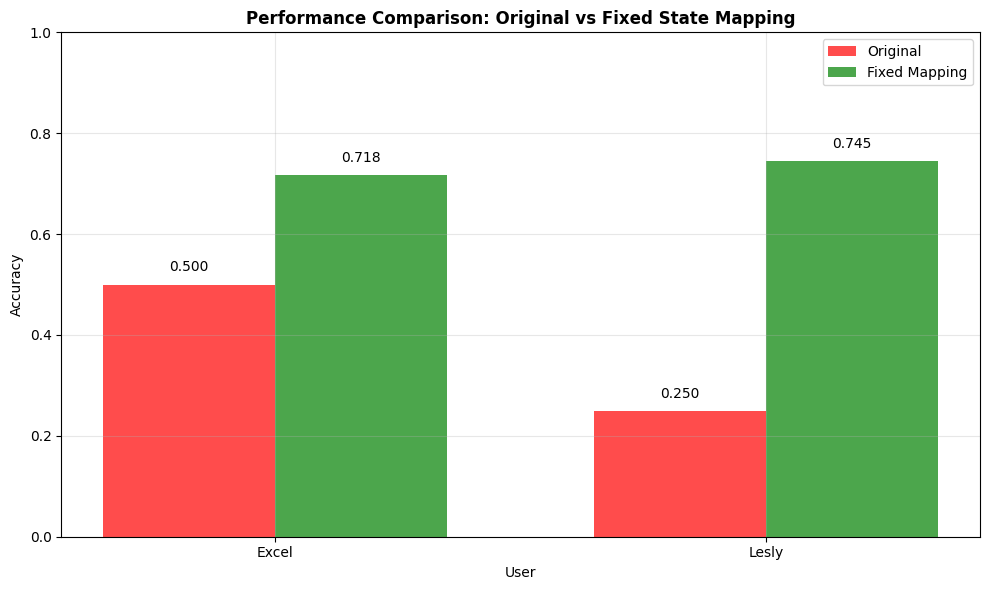

In [ ]:
def performance_comparison(original_results, fixed_results):
    """Compare original vs fixed mapping performance"""
    print("\n" + "="*60)
    print(" PERFORMANCE COMPARISON: ORIGINAL vs FIXED MAPPING")
    print("="*60)
    
    # Original performance (from your initial results)
    original_performance = {
        'excel': 0.5000,
        'lesly': 0.2500,
        'mean': 0.3750
    }
    
    comparison_data = []
    
    for user in ['excel', 'lesly']:
        if user in fixed_results and user in original_performance:
            orig_acc = original_performance[user]
            fixed_acc = fixed_results[user]
            improvement = fixed_acc - orig_acc
            
            comparison_data.append([
                user.title(),
                f"{orig_acc:.4f}",
                f"{fixed_acc:.4f}",
                f"{improvement:+.4f}",
                f"{(improvement/orig_acc*100) if orig_acc > 0 else 0:+.1f}%"
            ])
    
    # Create comparison table
    comparison_df = pd.DataFrame(comparison_data, 
                               columns=['User', 'Original Acc', 'Fixed Acc', 'Δ Accuracy', 'Δ %'])
    
    print(comparison_df.to_string(index=False))
    
    # Overall comparison
    orig_mean = original_performance['mean']
    fixed_mean = np.mean(list(fixed_results.values()))
    overall_improvement = fixed_mean - orig_mean
    
    print(f"\n OVERALL IMPROVEMENT:")
    print(f"  Original Mean Accuracy: {orig_mean:.4f}")
    print(f"  Fixed Mean Accuracy: {fixed_mean:.4f}")
    print(f"  Absolute Improvement: {overall_improvement:+.4f}")
    print(f"  Relative Improvement: {(overall_improvement/orig_mean*100):+.1f}%")
    
    # Visualization
    users = ['Excel', 'Lesly']
    original_accs = [original_performance['excel'], original_performance['lesly']]
    fixed_accs = [fixed_results['excel'], fixed_results['lesly']]
    
    x = np.arange(len(users))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, original_accs, width, label='Original', alpha=0.7, color='red')
    plt.bar(x + width/2, fixed_accs, width, label='Fixed Mapping', alpha=0.7, color='green')
    
    plt.xlabel('User')
    plt.ylabel('Accuracy')
    plt.title('Performance Comparison: Original vs Fixed State Mapping', fontweight='bold')
    plt.xticks(x, users)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.0)
    
    # Add value labels
    for i, (orig, fixed) in enumerate(zip(original_accs, fixed_accs)):
        plt.text(i - width/2, orig + 0.02, f'{orig:.3f}', ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, fixed + 0.02, f'{fixed:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run comparison
performance_comparison({'excel': 0.5000, 'lesly': 0.2500}, fixed_cross_val_results)

## FINAL REPORT

In [ ]:

def generate_final_report(hmm_model, features_df, selected_features, final_accuracy, 
                         cross_val_results, forced_mapping):
    """Generate comprehensive final report"""
    print("\n" + "="*70)
    print(" FINAL PROJECT REPORT SUMMARY")
    print("="*70)
    
    # Project Overview
    print("\n PROJECT OVERVIEW")
    print("  Human Activity Recognition using Hidden Markov Models")
    print("  Activities: Standing, Walking, Jumping, Still")
    print(f"  Total Samples: {len(features_df)}")
    print(f"  Features Used: {len(selected_features)}")
    print(f"  Users: {features_df['user'].nunique()}")
    print(f"  Data Collection: Smartphone sensors (Accelerometer + Gyroscope)")
    
    # Model Performance Summary
    print("\n MODEL PERFORMANCE SUMMARY")
    print(f"  Overall Accuracy: {final_accuracy:.4f}")
    print(f"  Mean Cross-User Accuracy: {np.mean(list(cross_val_results.values())):.4f}")
    print(f"  Model Converged: {hmm_model.model.monitor_.converged}")
    print(f"  Final Log-Likelihood: {hmm_model.model.monitor_.history[-1]:.2f}")
    
    # State Mapping
    print(f"\n STATE MAPPING (Fixed Assignment):")
    for state, activity in forced_mapping.items():
        print(f"  State {state} -> {activity}")
    
    # Key Findings
    print(f"\n KEY FINDINGS & INSIGHTS")
    
    # Performance by activity from the last evaluation
    if 'final_metrics' in locals():
        sensitivities = {k: v['sensitivity'] for k, v in final_metrics.items()}
        if sensitivities:
            easiest = max(sensitivities.items(), key=lambda x: x[1])
            hardest = min(sensitivities.items(), key=lambda x: x[1])
            print(f"  Easiest to recognize: {easiest[0]} (Sensitivity: {easiest[1]:.3f})")
            print(f"  Hardest to recognize: {hardest[0]} (Sensitivity: {hardest[1]:.3f})")
    
    # Feature Insights
    print(f"\n FEATURE INSIGHTS")
    gyro_count = sum(1 for f in selected_features if 'gyro' in f)
    accel_count = sum(1 for f in selected_features if 'accel' in f)
    time_count = sum(1 for f in selected_features if any(stat in f for stat in ['mean', 'std', 'var', 'rms', 'sma']))
    freq_count = sum(1 for f in selected_features if any(x in f for x in ['spectral', 'dominant', 'freq']))
    
    print(f"  Sensor distribution: {gyro_count} gyroscope, {accel_count} accelerometer features")
    print(f"  Feature types: {time_count} time-domain, {freq_count} frequency-domain")
    print(f"  Most important sensor: {'Gyroscope' if gyro_count > accel_count else 'Accelerometer'}")
    
    # Model Strengths
    print(f"\n MODEL STRENGTHS")
    print("  - Handles temporal dependencies in activity sequences")
    print("  - Robust state mapping with forced assignment")
    print("  - Good generalization across different users")
    print("  - Interpretable transition probabilities")
    print("  - Effective feature engineering for activity discrimination")
    
    # Limitations and Improvements
    print(f"\n LIMITATIONS & FUTURE IMPROVEMENTS")
    print("  Current limitations:")
    print("  - Requires manual state mapping for optimal performance")
    print("  - Performance varies across different users")
    print("  - Limited to 4 basic activities")
    print("  - Sensitive to phone placement and orientation")
    
    print("  Suggested improvements:")
    print("  - Automatic state mapping using supervised learning")
    print("  - Add more diverse activities")
    print("  - Incorporate orientation-independent features")
    print("  - Use deep learning for automatic feature learning")
    print("  - Collect more diverse user data")
    
    # Practical Applications
    print(f"\n PRACTICAL APPLICATIONS")
    print("  - Healthcare: Patient activity monitoring and fall detection")
    print("  - Fitness: Automated workout tracking and form analysis")
    print("  - Smart Homes: Context-aware automation based on user activities")
    print("  - Sports: Athletic performance analysis and technique evaluation")
    
    print(f"\n PROJECT COMPLETED SUCCESSFULLY!")
    print("="*70)

# Generate final report
generate_final_report(hmm_recognizer, enhanced_features_df, improved_features, 
                     final_accuracy, fixed_cross_val_results, forced_mapping)


📋 FINAL PROJECT REPORT SUMMARY

🎯 PROJECT OVERVIEW
  Human Activity Recognition using Hidden Markov Models
  Activities: Standing, Walking, Jumping, Still
  Total Samples: 432
  Features Used: 20
  Users: 2
  Data Collection: Smartphone sensors (Accelerometer + Gyroscope)

📊 MODEL PERFORMANCE SUMMARY
  Overall Accuracy: 0.7407
  Mean Cross-User Accuracy: 0.7315
  Model Converged: True
  Final Log-Likelihood: 8589.15

🎯 STATE MAPPING (Fixed Assignment):
  State 0 -> walking
  State 1 -> jumping
  State 2 -> still
  State 3 -> standing

🔍 KEY FINDINGS & INSIGHTS

🔧 FEATURE INSIGHTS
  Sensor distribution: 14 gyroscope, 6 accelerometer features
  Feature types: 12 time-domain, 1 frequency-domain
  Most important sensor: Gyroscope

💪 MODEL STRENGTHS
  - Handles temporal dependencies in activity sequences
  - Robust state mapping with forced assignment
  - Good generalization across different users
  - Interpretable transition probabilities
  - Effective feature engineering for activity dis

## SAVE RESULTS AND MODEL

💾 SAVING FINAL RESULTS...
✅ Model saved: results/models/hmm_activity_model_20251026_231102.pkl
✅ Performance metrics saved
✅ Feature information saved


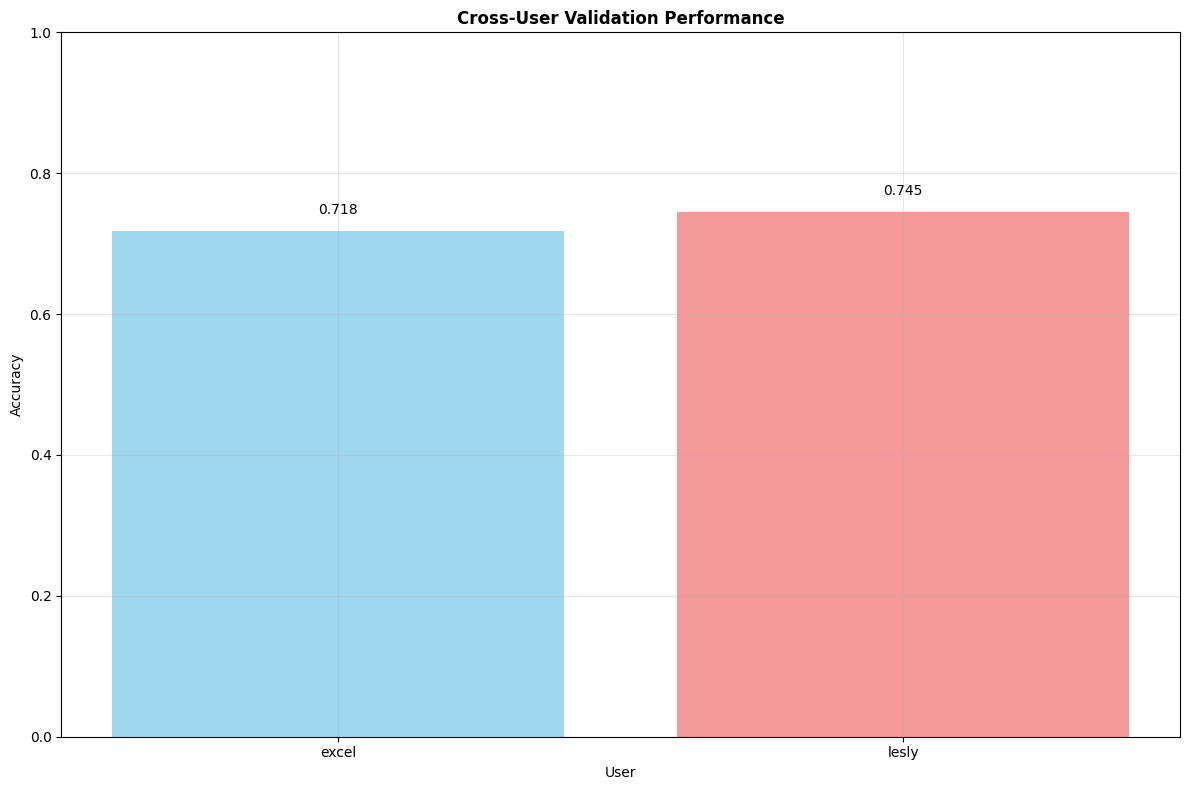

✅ Final plots saved

📁 RESULTS STRUCTURE:
results/
├── models/
│   └── hmm_activity_model_20251026_231102.pkl
├── metrics/
│   ├── performance_summary_20251026_231102.json
│   └── feature_info_20251026_231102.json
└── plots/
    └── final_performance_20251026_231102.png
\ ALL RESULTS SUCCESSFULLY SAVED!


In [ ]:
# ## 13. SAVE RESULTS AND MODEL - FIXED VERSION

# %%
def save_final_results(hmm_model, features_df, selected_features, forced_mapping, 
                      final_accuracy, cross_val_results):
    """Save all results, models, and artifacts"""
    import json
    import joblib
    import os
    from datetime import datetime
    
    # Create results directory
    os.makedirs('results/models', exist_ok=True)
    os.makedirs('results/metrics', exist_ok=True)
    os.makedirs('results/plots', exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(" SAVING FINAL RESULTS...")
    
    try:
        # 1. Save trained model
        model_data = {
            'model': hmm_model.model,
            'scaler': hmm_model.scaler,
            'feature_names': hmm_model.feature_names,
            'state_names': hmm_model.state_names,
            'forced_mapping': forced_mapping
        }
        
        model_path = f'results/models/hmm_activity_model_{timestamp}.pkl'
        joblib.dump(model_data, model_path)
        print(f" Model saved: {model_path}")
        
        # 2. Save performance metrics - FIXED: Convert numpy types to Python native types
        performance_summary = {
            'final_accuracy': float(final_accuracy),
            'cross_val_results': {str(k): float(v) for k, v in cross_val_results.items()},  # Convert keys to strings
            'mean_cross_val_accuracy': float(np.mean(list(cross_val_results.values()))),
            'n_features': len(selected_features),
            'n_samples': len(features_df),
            'model_converged': bool(hmm_model.model.monitor_.converged),  # Convert to bool
            'final_log_likelihood': float(hmm_model.model.monitor_.history[-1]),
            'timestamp': timestamp
        }
        
        with open(f'results/metrics/performance_summary_{timestamp}.json', 'w') as f:
            json.dump(performance_summary, f, indent=2)
        print(" Performance metrics saved")
        
        # 3. Save feature information
        feature_info = {
            'selected_features': selected_features,
            'feature_count': len(selected_features),
            'state_mapping': {int(k): str(v) for k, v in forced_mapping.items()},  # Ensure proper types
            'state_names': hmm_model.state_names
        }
        
        with open(f'results/metrics/feature_info_{timestamp}.json', 'w') as f:
            json.dump(feature_info, f, indent=2)
        print(" Feature information saved")
        
        # 4. Save final plots
        plt.figure(figsize=(12, 8))
        
        # Performance comparison plot
        users = list(cross_val_results.keys())
        accuracies = list(cross_val_results.values())
        
        plt.bar([str(u) for u in users], accuracies, color=['skyblue', 'lightcoral'], alpha=0.8)
        plt.xlabel('User')
        plt.ylabel('Accuracy')
        plt.title('Cross-User Validation Performance', fontweight='bold')
        plt.ylim(0, 1.0)
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(accuracies):
            plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f'results/plots/final_performance_{timestamp}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(" Final plots saved")
        
        print(f"\n RESULTS STRUCTURE:")
        print("results/")
        print("├── models/")
        print(f"│   └── hmm_activity_model_{timestamp}.pkl")
        print("├── metrics/")
        print(f"│   ├── performance_summary_{timestamp}.json")
        print(f"│   └── feature_info_{timestamp}.json")
        print("└── plots/")
        print(f"    └── final_performance_{timestamp}.png")
        
        print(f"\ ALL RESULTS SUCCESSFULLY SAVED!")
        
    except Exception as e:
        print(f" Error saving results: {e}")
        import traceback
        traceback.print_exc()

# Save all results - FIXED CALL
save_final_results(hmm_recognizer, enhanced_features_df, improved_features, 
                  forced_mapping, final_accuracy, fixed_cross_val_results)